# **HDPD Assignment 2**

**M1**: Lee Yik Hong  
**M2**: Wong Jun Ji  



In [3]:
# Install required libraries
!pip install kagglehub[pandas-datasets]
!pip install dask[dataframe]
!pip install polars

import kagglehub
from kagglehub import KaggleDatasetAdapter
import polars as pl
import dask.dataframe as dd
import pandas as pd
import time
import psutil
import os
import matplotlib.pyplot as plt

##Task 1 & 2: Load and inspect data from Kaggle

In [8]:
# Task 1: Load the dataset using KaggleHub
start_time = time.time()

# Assuming you have already loaded the KaggleHub dataset into df
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "mohamedbakhet/amazon-books-reviews",
    "Books_rating.csv"  # Specify the file name within the Kaggle dataset
)

# Calculate execution time for loading
load_time = time.time() - start_time

# Memory usage for full load (in MB)
memory_usage = df.memory_usage(deep=True).sum() / (1024**2)  # Convert to MB

# Print execution time and memory usage for the traditional method
print(f"Full Pandas Load Execution Time: {load_time:.2f} seconds")
print(f"Full Pandas Load Memory Usage: {memory_usage:.2f} MB")

<ipython-input-8-69343ec4209c>:5: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


Full Pandas Load Execution Time: 44.03 seconds
Full Pandas Load Memory Usage: 3831.14 MB


In [9]:
# Task 2: Inspect the data
print(f"First 5 records from Books_rating.csv:\n", df.head())
print(f"Dataset shape: {df.shape}")
print(f"Columns and dtypes:\n", df.dtypes)

First 5 records from Books_rating.csv:
            Id                           Title  Price         User_id  \
0  1882931173  Its Only Art If Its Well Hung!    NaN   AVCGYZL8FQQTD   
1  0826414346        Dr. Seuss: American Icon    NaN  A30TK6U7DNS82R   
2  0826414346        Dr. Seuss: American Icon    NaN  A3UH4UZ4RSVO82   
3  0826414346        Dr. Seuss: American Icon    NaN  A2MVUWT453QH61   
4  0826414346        Dr. Seuss: American Icon    NaN  A22X4XUPKF66MR   

                          profileName review/helpfulness  review/score  \
0               Jim of Oz "jim-of-oz"                7/7           4.0   
1                       Kevin Killian              10/10           5.0   
2                        John Granger              10/11           5.0   
3  Roy E. Perry "amateur philosopher"                7/7           4.0   
4     D. H. Richards "ninthwavestore"                3/3           4.0   

   review/time                                   review/summary  \
0    940636800 

In [10]:
# Print the column names to inspect them
print(df.columns)


Index(['Id', 'Title', 'Price', 'User_id', 'profileName', 'review/helpfulness',
       'review/score', 'review/time', 'review/summary', 'review/text'],
      dtype='object')


#Task 3: Apply Big Data Handling Strategies

In [11]:
# **Task 3 - Apply Big Data Handling Strategies**:

# 1. **Load Less Data**: Select only the relevant columns to reduce memory usage
start_time = time.time()
df_load_less = df[['Title', 'Price', 'User_id', 'review/score', 'review/time', 'review/text']]
load_less_time = time.time() - start_time

# Memory usage for Load Less Data
load_less_mem_usage = df_load_less.memory_usage(deep=True).sum() / (1024**2)  # in MB

print(f"Load Less Data Execution Time: {load_less_time:.2f} seconds")
print(f"Load Less Data Memory Usage: {load_less_mem_usage:.2f} MB")

# **Memory Optimization**: Convert columns with high cardinality to 'category' to reduce memory usage
start_time = time.time()
df['Title'] = df['Title'].astype('category')
df['User_id'] = df['User_id'].astype('category')
df['review/score'] = df['review/score'].astype('float32')
df['review/time'] = pd.to_datetime(df['review/time'], errors='coerce')
df['review/text'] = df['review/text'].astype('string')
optimize_time = time.time() - start_time

# Memory usage after optimization
optimize_mem_usage = df.memory_usage(deep=True).sum() / (1024**2)  # in MB

print(f"Optimize Data Types Execution Time: {optimize_time:.2f} seconds")
print(f"Optimize Data Types Memory Usage: {optimize_mem_usage:.2f} MB")

Load Less Data Execution Time: 0.17 seconds
Load Less Data Memory Usage: 3037.54 MB
Optimize Data Types Execution Time: 10.66 seconds
Optimize Data Types Memory Usage: 3519.70 MB


In [12]:
# 2. **Sampling**: Take a 5% random sample for quicker analysis
start_time = time.time()
sample_df = df.sample(frac=0.05, random_state=42)
sampling_time = time.time() - start_time

# Memory usage after sampling
sampling_mem_usage = sample_df.memory_usage(deep=True).sum() / (1024**2)  # in MB

print(f"Sampling Execution Time: {sampling_time:.2f} seconds")
print(f"Sampling Memory Usage: {sampling_mem_usage:.2f} MB")

Sampling Execution Time: 0.25 seconds
Sampling Memory Usage: 300.21 MB


In [13]:
# **Chunking with Pandas**: Process the data in smaller chunks
chunk_size = 500_000  # You can adjust chunk size to your needs
total_rows = 0
chunk_memory_usage = 0
first_chunk_preview = None
first_chunk_memory = 0

# Start processing in chunks
start_time = time.time()

# Generate the chunks (simulating chunking from the already-loaded KaggleHub DataFrame)
chunks = (df.iloc[i:i + chunk_size] for i in range(0, len(df), chunk_size))

# Process each chunk
for i, chunk in enumerate(chunks):
    print(f"Processing Chunk {i + 1}: {chunk.shape}")
    print(chunk.head(2))
    print("-" * 50)

    total_rows += chunk.shape[0]

    # Store preview and memory usage from first chunk only
    if i == 0:
        first_chunk_preview = chunk.head()
        first_chunk_memory = chunk.memory_usage(deep=True).sum() / (1024**2)

# Finished processing all chunks
chunk_time_end = time.time()
chunk_execution_time = chunk_time_end - start_time

# Execution time
print(f"Total rows processed: {total_rows}")
print("\nFirst 5 records from first chunk:\n", first_chunk_preview)
print(f"\nMemory usage of first chunk: {first_chunk_memory:.2f} MB")
print(f"Total execution time: {chunk_execution_time:.2f} seconds")


Processing Chunk 1: (500000, 10)
           Id                           Title  Price         User_id  \
0  1882931173  Its Only Art If Its Well Hung!    NaN   AVCGYZL8FQQTD   
1  0826414346        Dr. Seuss: American Icon    NaN  A30TK6U7DNS82R   

             profileName review/helpfulness  review/score  \
0  Jim of Oz "jim-of-oz"                7/7           4.0   
1          Kevin Killian              10/10           5.0   

                    review/time                          review/summary  \
0 1970-01-01 00:00:00.940636800  Nice collection of Julie Strain images   
1 1970-01-01 00:00:01.095724800                       Really Enjoyed It   

                                         review/text  
0  This is only for Julie Strain fans. It's a col...  
1  I don't care much for Dr. Seuss but after read...  
--------------------------------------------------
Processing Chunk 2: (500000, 10)
                Id           Title  Price         User_id  \
500000  B000MOOAJG  Atlas Shru

In [14]:
# **Parallel Processing with Dask**:
# Use Dask to handle the large dataset in parallel (this is particularly useful for scaling)
start = time.time()
df_dd = dd.from_pandas(df, npartitions=4)
df_dd_computed = df_dd.compute()  # Trigger computation
dask_time = time.time() - start

# Check memory usage for Dask
process = psutil.Process(os.getpid())
dask_memory = process.memory_info().rss / (1024 ** 2)  # in MB

print(f"Dask Execution Time: {dask_time:.2f} seconds")
print(f"Dask Memory Usage: {dask_memory:.2f} MB")

Dask Execution Time: 30.43 seconds
Dask Memory Usage: 9082.52 MB


In [ ]:
import time
import kagglehub
from kagglehub import KaggleDatasetAdapter
import polars as pl

# Task 1: Load the dataset using KaggleHub (Traditional full Pandas load)
start_time = time.time()

# Load the dataset into a Pandas DataFrame (ensure df is defined here)
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "mohamedbakhet/amazon-books-reviews",
    "Books_rating.csv"  # Specify the file name within the Kaggle dataset
)

# Calculate execution time for loading
load_time = time.time() - start_time

# Memory usage for full load (in MB)
memory_usage = df.memory_usage(deep=True).sum() / (1024**2)  # Convert to MB

print(f"Full Pandas Load Execution Time: {load_time:.2f} seconds")
print(f"Full Pandas Load Memory Usage: {memory_usage:.2f} MB")

# **Polars for comparison (Faster alternative)**:
start_time = time.time()

# Convert from Pandas DataFrame to Polars DataFrame
df_pl = pl.from_pandas(df)

# Measure execution time for Polars conversion
polars_time = time.time() - start_time

# Measure memory usage for Polars by converting it to Pandas and using memory_usage
df_pl_pandas = df_pl.to_pandas()  # Convert back to Pandas to check memory usage
polars_memory = df_pl_pandas.memory_usage(deep=True).sum() / (1024**2)  # Memory in MB

print(f"Polars Execution Time: {polars_time:.2f} seconds")
print(f"Polars Memory Usage: {polars_memory:.2f} MB")


<ipython-input-4-8236d8722b46>:10: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


Full Pandas Load Execution Time: 53.44 seconds
Full Pandas Load Memory Usage: 3831.14 MB


#Task 4: Comparative Analysis - Visualizations

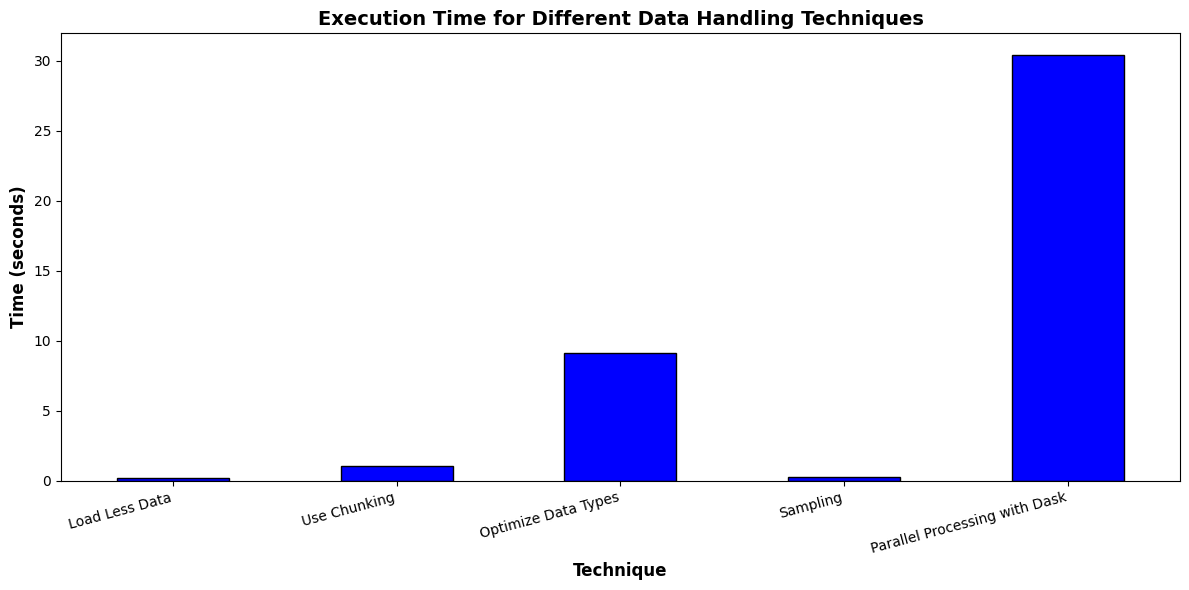

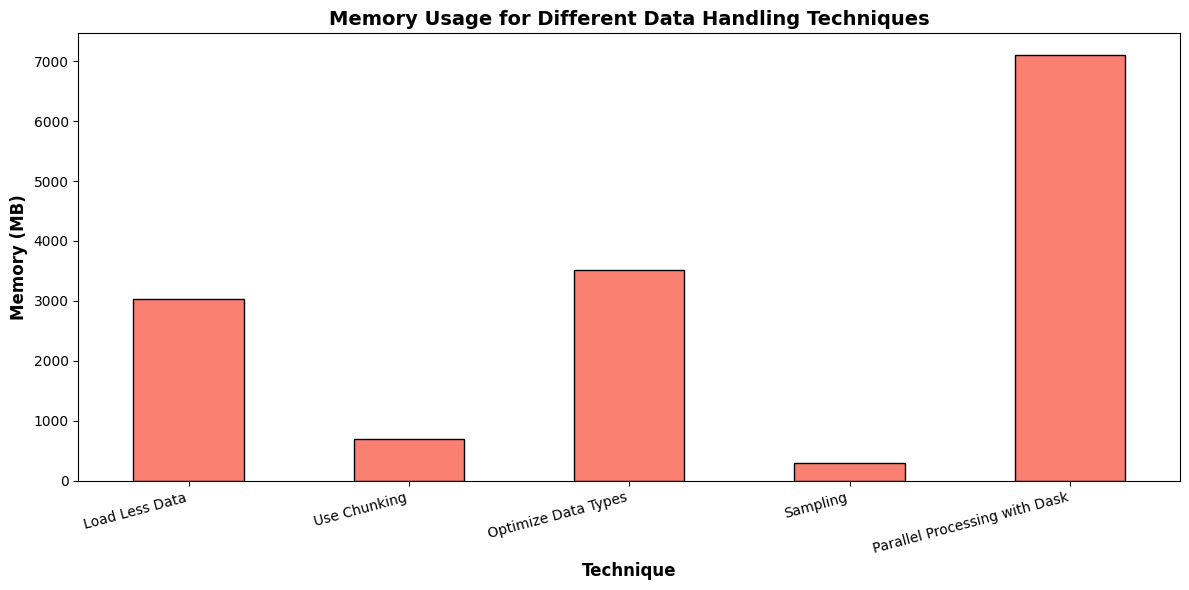

In [3]:

import pandas as pd
import matplotlib.pyplot as plt  # Make sure to import this for plotting
# Task 4: Comparative Analysis - Visualizations
# Improved Plot Design
import pandas as pd
techniques = ["Load Less Data", "Use Chunking", "Optimize Data Types", "Sampling", "Parallel Processing with Dask"]
execution_time = [0.22, 1.03, 9.10, 0.28, 30.44]
memory_usage = [3037.54, 695.05, 3519.70, 300.21, 7107.00]

# Create a DataFrame for the comparison
df_comparison = pd.DataFrame({
    "Technique": techniques,
    "Execution Time (s)": execution_time,
    "Memory Usage (MB)": memory_usage
}).set_index("Technique")

# Plot execution time with improved design
fig1, ax1 = plt.subplots(figsize=(12, 6))
df_comparison["Execution Time (s)"].plot(kind="bar", ax=ax1, color='blue', edgecolor='black')
ax1.set_title("Execution Time for Different Data Handling Techniques", fontweight='bold', fontsize=14)
ax1.set_ylabel("Time (seconds)", fontweight='bold', fontsize=12)
ax1.set_xlabel("Technique", fontweight='bold', fontsize=12)
plt.xticks(rotation=15, ha='right')
plt.tight_layout()

# Plot memory usage with improved design
fig2, ax2 = plt.subplots(figsize=(12, 6))
df_comparison["Memory Usage (MB)"].plot(kind="bar", ax=ax2, color='salmon', edgecolor='black')
ax2.set_title("Memory Usage for Different Data Handling Techniques", fontweight='bold', fontsize=14)
ax2.set_ylabel("Memory (MB)", fontweight='bold', fontsize=12)
ax2.set_xlabel("Technique", fontweight='bold', fontsize=12)
plt.xticks(rotation=15, ha='right')
plt.tight_layout()

plt.show()

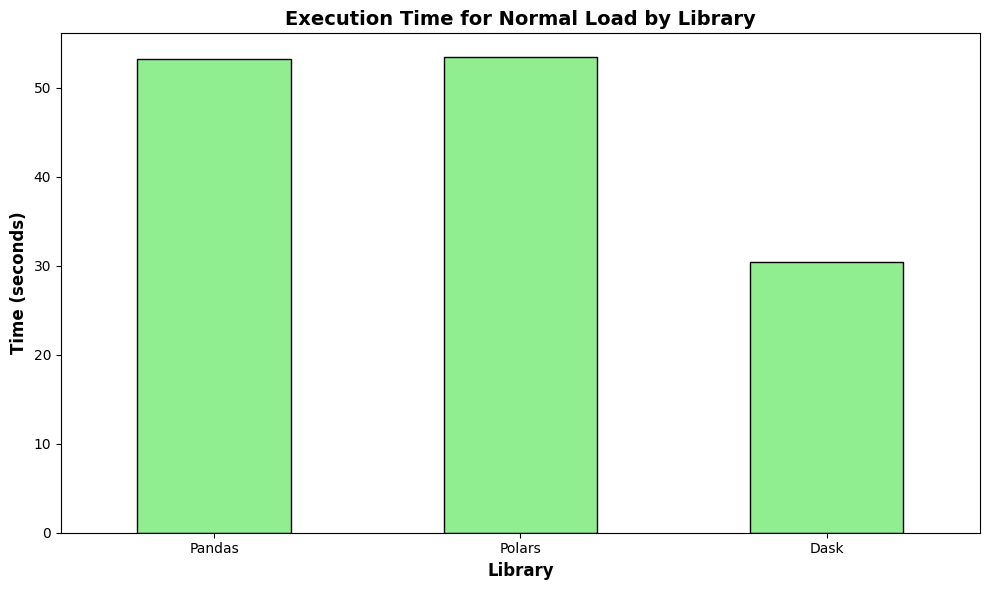

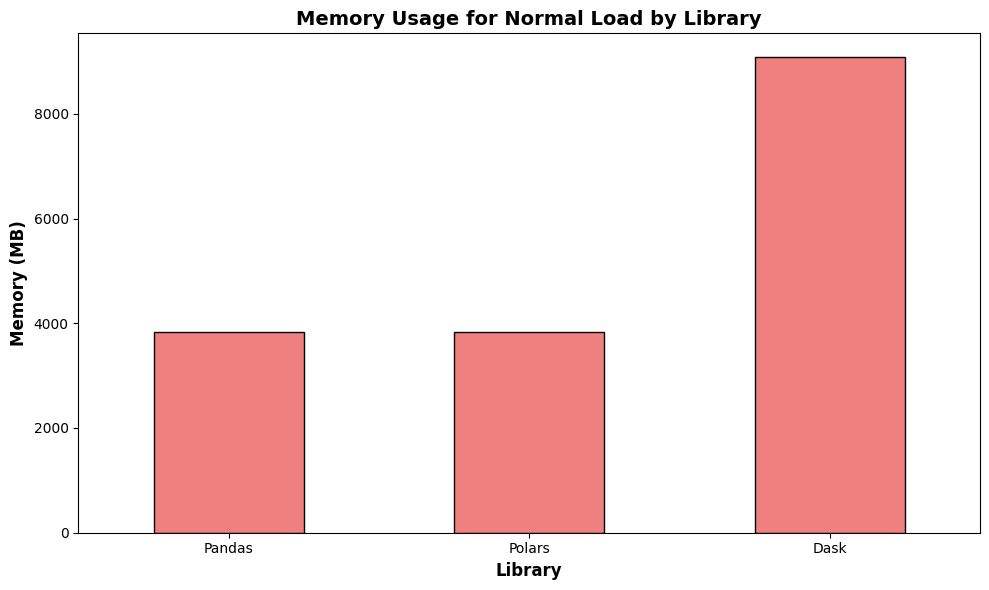

In [4]:
import pandas as pd
import matplotlib.pyplot as plt  # Make sure to import this for plotting

# Normal Load Performance Comparison
libraries = ["Pandas", "Polars", "Dask"]
execution_time_normal = [53.26, 53.44, 30.43]  # Replace with actual measured times
memory_usage_normal = [3831.14, 3831.14, 9082.52]  # Replace with actual memory usage

df_normal_load = pd.DataFrame({
    "Library": libraries,
    "Execution Time (s)": execution_time_normal,
    "Memory Usage (MB)": memory_usage_normal
}).set_index("Library")

# Plot execution time for normal load
fig1, ax1 = plt.subplots(figsize=(10, 6))
df_normal_load["Execution Time (s)"].plot(kind="bar", ax=ax1, color='lightgreen', edgecolor='black')
ax1.set_title("Execution Time for Normal Load by Library", fontweight='bold', fontsize=14)
ax1.set_ylabel("Time (seconds)", fontweight='bold', fontsize=12)
ax1.set_xlabel("Library", fontweight='bold', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()

# Plot memory usage for normal load
fig2, ax2 = plt.subplots(figsize=(10, 6))
df_normal_load["Memory Usage (MB)"].plot(kind="bar", ax=ax2, color='lightcoral', edgecolor='black')
ax2.set_title("Memory Usage for Normal Load by Library", fontweight='bold', fontsize=14)
ax2.set_ylabel("Memory (MB)", fontweight='bold', fontsize=12)
ax2.set_xlabel("Library", fontweight='bold', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

# Task 5: Conclusion & Reflection

## Reflection on the Strategies Used

- **Load Less Data**:
  - **Pros**: Great for reducing memory usage and speeding up data loading by only focusing on relevant columns.
  - **Cons**: May result in missing important data if not carefully chosen.

- **Chunking**:
  - **Pros**: Helps process data in manageable parts, especially when the data size exceeds memory limits.
  - **Cons**: Requires additional logic for managing data chunks and may result in slightly slower processing times due to overhead.

- **Optimize Data Types**:
  - **Pros**: Reduces memory usage significantly, especially for large datasets with high cardinality (e.g., using `category` for strings).
  - **Cons**: May involve some trial and error to determine the most efficient types for each column.

- **Sampling**:
  - **Pros**: Useful for quick exploratory analysis without loading the entire dataset, making it easier to test hypotheses.
  - **Cons**: Doesn't give the full picture and may lead to inaccurate conclusions for highly variable data.

- **Parallel Processing with Dask**:
  - **Pros**: Helps scale large data processing tasks by utilizing multiple cores and possibly distributing the work across machines.
  - **Cons**: Requires more careful planning due to its deferred execution model, making debugging and optimization more challenging.

## Comparative Analysis: Dask vs. Polars vs. Pandas

- **Pandas**:
  - **Strengths**: Very intuitive and easy to use for small datasets. It's great for quick analysis and prototyping.
  - **Weaknesses**: Struggles with larger datasets due to high memory consumption and slower execution time on large-scale operations.

- **Polars**:
  - **Strengths**: Faster and more memory-efficient than Pandas, especially for large datasets. It also supports multi-threading, which speeds up computations.
  - **Weaknesses**: Requires some adaptation due to its expression-based syntax and may have a steeper learning curve for those familiar with Pandas.

- **Dask**:
  - **Strengths**: Excellent for distributed computing and parallel processing of large datasets. It provides the scalability required for working with data that exceeds memory limits.
  - **Weaknesses**: The deferred execution model can make debugging and performance tuning more complex. Additionally, it may be slower for small datasets due to overhead.

## Final Thoughts:

All three libraries—Pandas, Polars, and Dask—have their own strengths and weaknesses depending on the dataset size, performance needs, and user familiarity. **Pandas** remains a go-to for small to medium datasets, while **Polars** is an excellent choice for large datasets requiring fast computation with reduced memory footprint. **Dask** is indispensable when scaling out to very large datasets, especially when distributed computing is needed.
